# setup

In [0]:
!wget -O pulution.npy 'https://drive.google.com/uc?export=download&id=1YNM-N3HrER8NKVE16C3EavlSTGAlacjJ'

--2020-06-02 10:07:51--  https://drive.google.com/uc?export=download&id=1YNM-N3HrER8NKVE16C3EavlSTGAlacjJ
Resolving drive.google.com (drive.google.com)... 172.217.203.113, 172.217.203.100, 172.217.203.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hgs5l7heiqlg030osca8iqpjtu8v759m/1591092450000/01019297866349987175/*/1YNM-N3HrER8NKVE16C3EavlSTGAlacjJ?e=download [following]
--2020-06-02 10:07:52--  https://doc-00-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hgs5l7heiqlg030osca8iqpjtu8v759m/1591092450000/01019297866349987175/*/1YNM-N3HrER8NKVE16C3EavlSTGAlacjJ?e=download
Resolving doc-00-5k-docs.googleusercontent.com (doc-00-5k-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connecting to doc-00-5k-docs.googleusercontent.com (doc

In [0]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import cv2
from tqdm import tqdm
import copy

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer , KNNImputer
from sklearn.impute import MissingIndicator

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D , MaxPooling2D
from keras.layers import SimpleRNN, LSTM, GRU
from keras.layers import Embedding
from keras.layers.normalization import BatchNormalization
# new package only available in tf-nightly
# from keras.preprocessing import timeseries_dataset_from_array
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.preprocessing.image import  ImageDataGenerator as IDG


np.random.seed(1234)

# load data

In [0]:
X = np.load('./pulution.npy')

In [0]:
X.shape

(43799, 8)

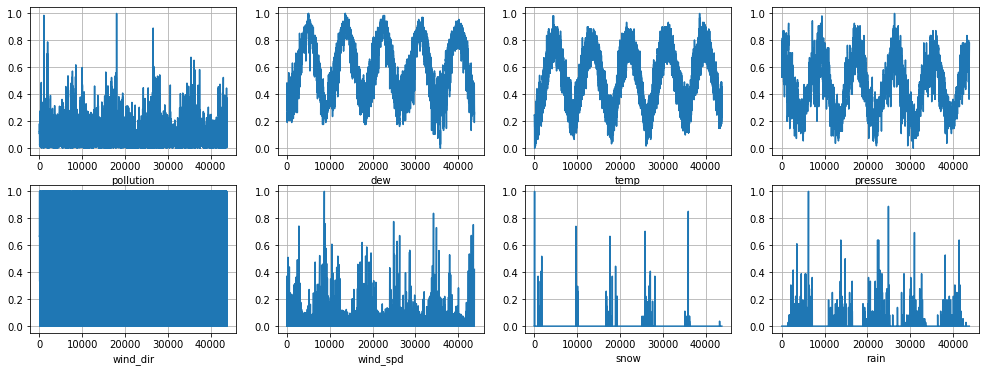

In [0]:
f_names = ['pollution', 'dew', 'temp', 'pressure', 'wind_dir', 'wind_spd', 'snow', 'rain']
plt.figure(figsize=(17, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(X[:, i])
    plt.grid()
    plt.xlabel(f_names[i])

In [0]:
X_miss = copy.deepcopy(X)

In [0]:
n = int(0.2 * X_miss.shape[0])
for i in range(8):
    mask = np.arange(0, X_miss.shape[0])
    np.random.shuffle(mask)
    X_miss[mask[:n], i] = None

In [0]:
X_miss

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
               nan],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
               nan],
       [0.15995975,        nan, 0.22950819, ...,        nan, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.40558836, 0.        ,
        0.        ],
       [       nan, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829,        nan, 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ]], dtype=float32)

# KNN Imputer

In [0]:
X_KNN = np.hstack((copy.deepcopy(X_miss), np.arange(0, X.shape[0]).reshape(-1, 1)))
indicator = MissingIndicator(features='all')
miss_mask = indicator.fit_transform(X_KNN)

In [0]:
imputer = KNNImputer(n_neighbors=5)
X_pred = imputer.fit_transform(X_KNN)

In [0]:
def MSE(X, X_pred, miss_mask):
    return np.sum(np.power(X[miss_mask[:, :-1]] - X_pred[miss_mask] , 2)) / np.sum(miss_mask)

In [0]:
MSE(X , X_pred, miss_mask)

0.010138746964915032

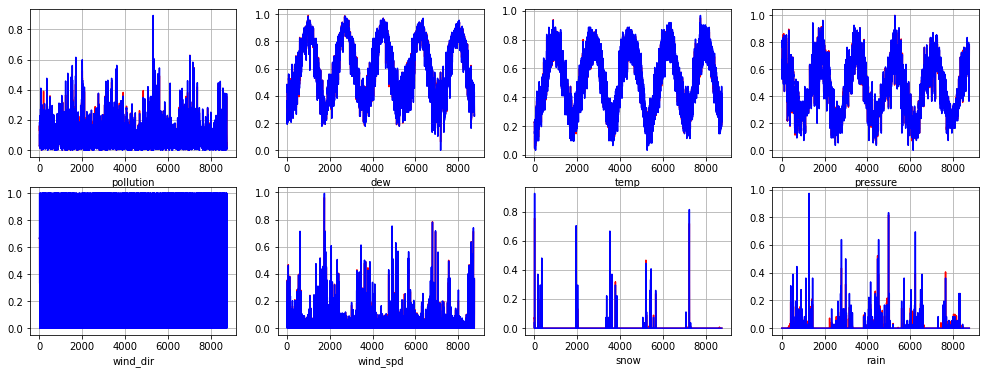

In [0]:
f_names = ['pollution', 'dew', 'temp', 'pressure', 'wind_dir', 'wind_spd', 'snow', 'rain']
plt.figure(figsize=(17, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(X_pred[miss_mask[:, i], i], c = 'red')
    plt.plot(X[miss_mask[:,i], i], c='blue')
    plt.grid()
    plt.xlabel(f_names[i])

# iterative imputer

In [0]:
X_Iter = np.hstack((copy.deepcopy(X_miss), np.arange(0, X.shape[0]).reshape(-1, 1)))
indicator = MissingIndicator(features='all')
miss_mask = indicator.fit_transform(X_Iter)

In [0]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

## BayesianRidge: regularized linear regression

In [0]:
imputer = IterativeImputer(BayesianRidge())
X_pred = imputer.fit_transform(X_Iter)

In [0]:
MSE(X , X_pred, miss_mask)

0.017989312535288536

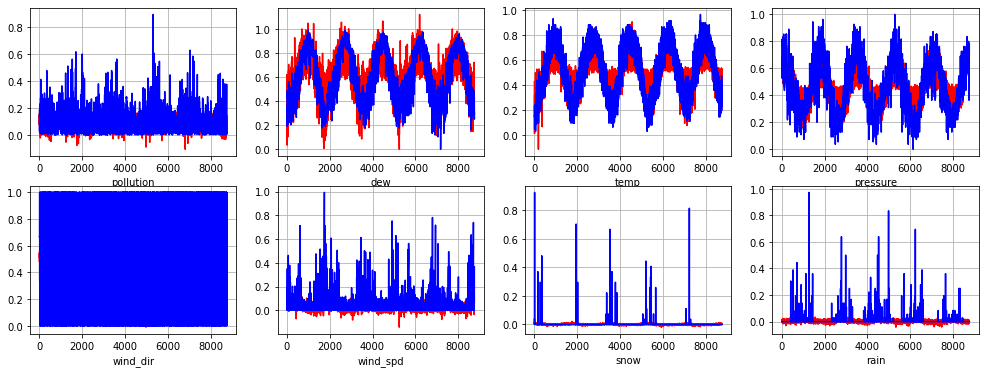

In [0]:
f_names = ['pollution', 'dew', 'temp', 'pressure', 'wind_dir', 'wind_spd', 'snow', 'rain']
plt.figure(figsize=(17, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(X_pred[miss_mask[:, i], i], c = 'red')
    plt.plot(X[miss_mask[:,i], i], c='blue')
    plt.grid()
    plt.xlabel(f_names[i])

## DecisionTreeRegressor: non-linear regression

In [0]:
imputer = IterativeImputer(DecisionTreeRegressor(max_features='sqrt'))
X_pred = imputer.fit_transform(X_Iter)

In [0]:
MSE(X , X_pred, miss_mask)

0.024445973289451715

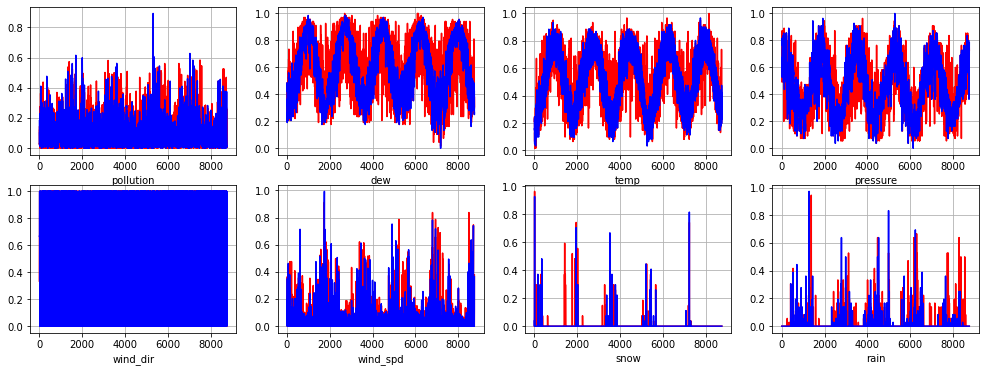

In [0]:
f_names = ['pollution', 'dew', 'temp', 'pressure', 'wind_dir', 'wind_spd', 'snow', 'rain']
plt.figure(figsize=(17, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(X_pred[miss_mask[:, i], i], c = 'red')
    plt.plot(X[miss_mask[:,i], i], c='blue')
    plt.grid()
    plt.xlabel(f_names[i])

## ExtraTreesRegressor: similar to missForest in R

In [0]:
imputer = IterativeImputer(ExtraTreesRegressor())
X_pred = imputer.fit_transform(X_Iter)

In [0]:
MSE(X , X_pred, miss_mask)

0.012361838171651913

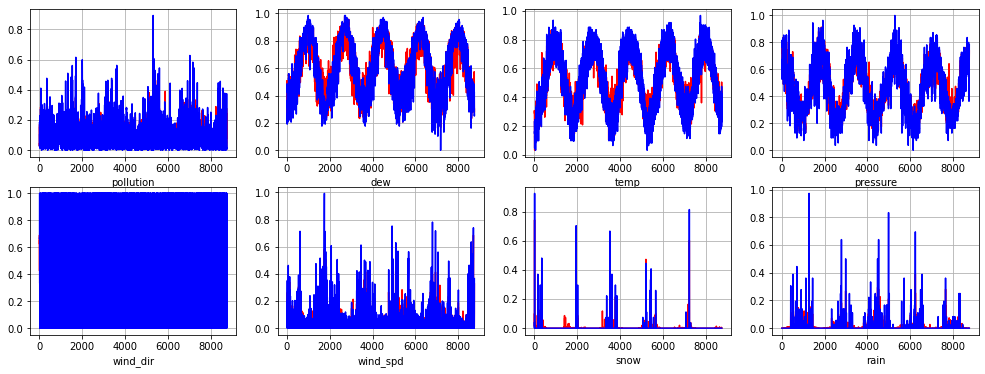

In [0]:
f_names = ['pollution', 'dew', 'temp', 'pressure', 'wind_dir', 'wind_spd', 'snow', 'rain']
plt.figure(figsize=(17, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(X_pred[miss_mask[:, i], i], c = 'red')
    plt.plot(X[miss_mask[:,i], i], c='blue')
    plt.grid()
    plt.xlabel(f_names[i])

## KNeighborsRegressor: comparable to other KNN imputation approaches

In [0]:
imputer = IterativeImputer(KNeighborsRegressor())
X_pred = imputer.fit_transform(X_Iter)

In [0]:
MSE(X , X_pred, miss_mask)

0.01014748197173207

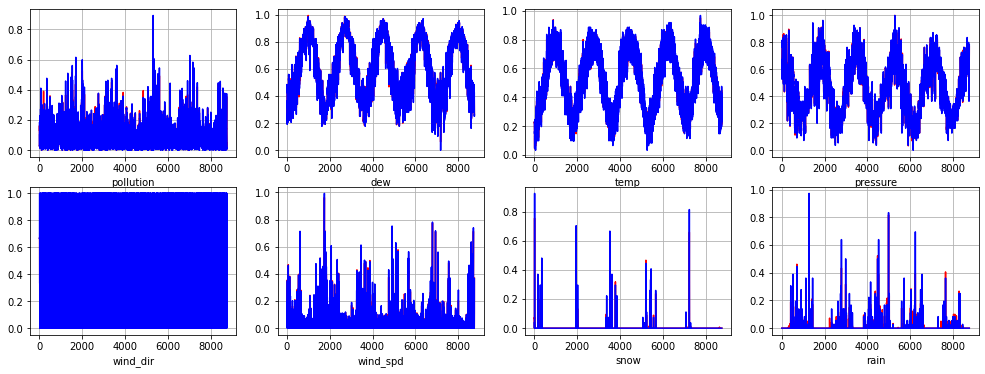

In [0]:
f_names = ['pollution', 'dew', 'temp', 'pressure', 'wind_dir', 'wind_spd', 'snow', 'rain']
plt.figure(figsize=(17, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(X_pred[miss_mask[:, i], i], c = 'red')
    plt.plot(X[miss_mask[:,i], i], c='blue')
    plt.grid()
    plt.xlabel(f_names[i])

In [0]:
def MSEI(X, X_pred, miss_mask, i):
    return np.sum(np.power(X[miss_mask[:,i], i] - X_pred[miss_mask[:, i], i] , 2)) / np.sum(miss_mask[:, i])

In [0]:
for i in range(8):
    print(MSEI(X, X_pred, miss_mask, i))

0.0006129148162046969
0.00035319678571542123
0.0005739906026470082
0.00015332378423673734
0.0784194026980097
0.0005745162238887405
0.00013304285509994288
0.00035946800805429865


In [0]:
for i in range(8):
    print(f'{f_names[i]} : {MSEI(X, X_pred, miss_mask, i)}')

pollution : 0.0006129148162046969
dew : 0.00035319678571542123
temp : 0.0005739906026470082
pressure : 0.00015332378423673734
wind_dir : 0.0784194026980097
wind_spd : 0.0005745162238887405
snow : 0.00013304285509994288
rain : 0.00035946800805429865


# train test split

In [0]:
X_train = copy.deepcopy(X[:35040, :])
X_test  = copy.deepcopy(X[35040:, :])
X_train.shape, X_test.shape

((35040, 8), (8759, 8))

# add missing to train data

In [0]:
n = int(0.2 * X_train.shape[0])
for i in range(8):
    mask = np.arange(0, X_train.shape[0])
    np.random.shuffle(mask)
    X_train[mask[:n], i] = None

X_KNN = np.hstack((copy.deepcopy(X_train), np.arange(0, X_train.shape[0]).reshape(-1, 1)))
indicator = MissingIndicator(features='all')
miss_mask = indicator.fit_transform(X_KNN)

# impute missed data

In [0]:
imputer = IterativeImputer(KNeighborsRegressor())
X_train_imputed = imputer.fit_transform(X_KNN)

In [0]:
X_train = copy.deepcopy(X[:35040, :])

In [0]:
MSEI(X_train , X_train_imputed, miss_mask,0)

0.0006985356725201582

In [0]:
X_train_imputed = X_train_imputed[:, :-1]

# train GRU model on imputed data

In [0]:
def make_model(cell, optimizer, cost, wnd_size, n_feature, drop_out = 0):
    model = keras.Sequential()
    model.add(cell(1, input_shape=(wnd_size, n_feature),dropout=drop_out, recurrent_dropout=drop_out))
    model.compile(loss=cost, optimizer=optimizer)
    return model

def plot_loss(cell_name, optimizer, cost, history, desc=''):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(desc+f'{cell_name}, {optimizer}, {cost}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'valid'], loc='upper left')
    plt.grid()
    plt.show()

def plot_performance(cell_name, optimizer, cost, model, train_f, train_t, test_f, test_t, desc=''):
    # model.trainable = False
    # model.compile(loss=cost, optimizer=optimizer)

    plt.figure(figsize=(17, 7))
    
    plt.subplot(1, 2, 1)
    # train
    pred = keras.backend.eval(model(tf.convert_to_tensor(train_f)))
    plt.plot(train_t, label='target')
    plt.plot(pred, label='pred')
    plt.grid()
    plt.xlabel('h')
    plt.ylabel('pollution')
    plt.title(desc+f'{cell_name}, {optimizer}, {cost} on train')
    plt.legend()

    print(f'mse on train: {np.sum(np.power(pred- train_t, 2))/len(train_t)}')

    plt.subplot(1, 2, 2)
    # test
    pred = keras.backend.eval(model(tf.convert_to_tensor(test_f)))
    plt.plot(test_t, label='target')
    plt.plot(pred, label='pred')
    plt.grid()
    plt.xlabel('h')
    plt.ylabel('pollution')
    plt.title(f'{cell_name}, {optimizer}, {cost} on test')
    plt.legend()
    print(f'mse on test: {np.sum(np.power(pred- test_t, 2))/len(test_t)}')
    plt.show()

def TimeSeriesGen2np(gen, wnd_size, n_feature):
    f = []
    t = []
    for batch in gen:
        f.append(batch[0])
        t.append(batch[1])
    return np.array(f).reshape(-1, wnd_size, n_feature), np.array(t).reshape(-1, 1)

In [0]:
hour_gen_train = TimeseriesGenerator(X_train, X_train[:,0], length = 23, sampling_rate=1 , start_index=3*7*24 - 23,batch_size=1)
hour_gen_test = TimeseriesGenerator(X_test, X_test[:,0], length = 23, sampling_rate=1 , start_index=3*7*24 - 23,batch_size=1)
hour_gen_imput = TimeseriesGenerator(X_train_imputed, X_train_imputed[:,0], length = 23, sampling_rate=1 , start_index=3*7*24 - 23,batch_size=1)

In [0]:
len(hour_gen_train), len(hour_gen_test), len(hour_gen_imput)

(34536, 8255, 34536)

In [0]:
hour_train_f, hour_train_t = TimeSeriesGen2np(hour_gen_train, 23, 8)
hour_test_f, hour_test_t = TimeSeriesGen2np(hour_gen_test, 23, 8)
hour_train_imput_f, hour_train_imput_t = TimeSeriesGen2np(hour_gen_imput, 23, 8)

In [0]:
model = make_model(GRU, 'adam', 'mse', 23, 8)
model_imput = make_model(GRU, 'adam', 'mse', 23, 8)

In [0]:
model_history = model.fit(hour_train_f, hour_train_t, validation_data=(hour_test_f, hour_test_t), epochs=50, batch_size=256)

Train on 34536 samples, validate on 8255 samples
Epoch 1/50
34536/34536 [==============================] - 12s 362us/step - loss: 0.0996 - val_loss: 0.0261
Epoch 2/50
34536/34536 [==============================] - 11s 316us/step - loss: 0.0224 - val_loss: 0.0206
Epoch 3/50
34536/34536 [==============================] - 11s 314us/step - loss: 0.0175 - val_loss: 0.0162
Epoch 4/50
34536/34536 [==============================] - 11s 304us/step - loss: 0.0138 - val_loss: 0.0128
Epoch 5/50
34536/34536 [==============================] - 11s 308us/step - loss: 0.0110 - val_loss: 0.0103
Epoch 6/50
34536/34536 [==============================] - 11s 311us/step - loss: 0.0090 - val_loss: 0.0084
Epoch 7/50
34536/34536 [==============================] - 10s 303us/step - loss: 0.0076 - val_loss: 0.0072
Epoch 8/50
34536/34536 [==============================] - 11s 306us/step - loss: 0.0065 - val_loss: 0.0062
Epoch 9/50
34536/34536 [==============================] - 11s 304us/step - loss: 0.0057 - val_l

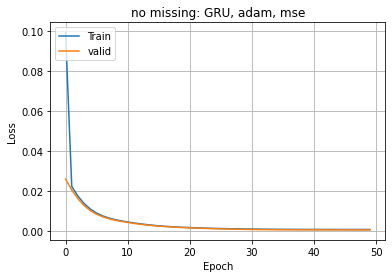

In [0]:
plot_loss('GRU', 'adam', 'mse', model_history, 'no missing: ')

mse on train: 0.0008137297900926467
mse on test: 0.0006051393366813082


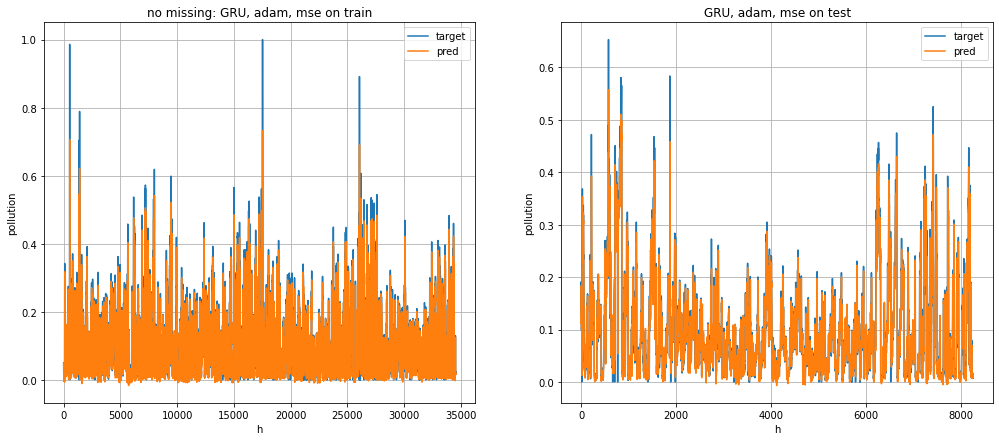

In [0]:
plot_performance('GRU', 'adam', 'mse', model, hour_train_f, hour_train_t, hour_test_f, hour_test_t, desc='no missing: ')

In [0]:
imput_history = model_imput.fit(hour_train_imput_f, hour_train_imput_t, validation_data=(hour_test_f, hour_test_t), epochs=50, batch_size=256)

Train on 34536 samples, validate on 8255 samples
Epoch 1/50
34536/34536 [==============================] - 11s 320us/step - loss: 0.1053 - val_loss: 0.0416
Epoch 2/50
34536/34536 [==============================] - 11s 306us/step - loss: 0.0231 - val_loss: 0.0160
Epoch 3/50
34536/34536 [==============================] - 11s 311us/step - loss: 0.0132 - val_loss: 0.0131
Epoch 4/50
34536/34536 [==============================] - 11s 308us/step - loss: 0.0115 - val_loss: 0.0117
Epoch 5/50
34536/34536 [==============================] - 11s 306us/step - loss: 0.0103 - val_loss: 0.0105
Epoch 6/50
34536/34536 [==============================] - 11s 307us/step - loss: 0.0094 - val_loss: 0.0096
Epoch 7/50
34536/34536 [==============================] - 11s 310us/step - loss: 0.0086 - val_loss: 0.0089
Epoch 8/50
34536/34536 [==============================] - 11s 311us/step - loss: 0.0081 - val_loss: 0.0084
Epoch 9/50
34536/34536 [==============================] - 11s 310us/step - loss: 0.0076 - val_l

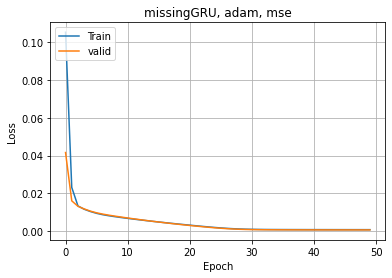

In [0]:
plot_loss('GRU', 'adam', 'mse', imput_history, 'missing')

mse on train: 0.0007046574598554939
mse on test: 0.000564276500588688


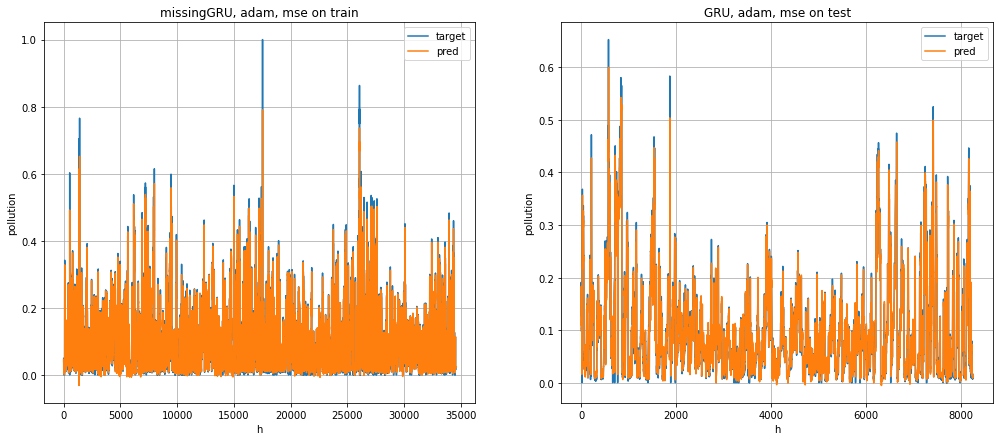

In [0]:
plot_performance('GRU', 'adam', 'mse', model_imput, hour_train_imput_f.astype('float32'), hour_train_imput_t.astype('float32'), hour_test_f, hour_test_t, desc='missing')

# train LSTM model on imputed data

In [0]:
model = make_model(LSTM, 'adam', 'mse', 23, 8)
model_imput = make_model(LSTM, 'adam', 'mse', 23, 8)

In [0]:
model_history = model.fit(hour_train_f, hour_train_t, validation_data=(hour_test_f, hour_test_t), epochs=50, batch_size=256)

Train on 34536 samples, validate on 8255 samples
Epoch 1/50
34536/34536 [==============================] - 9s 249us/step - loss: 0.0089 - val_loss: 0.0066
Epoch 2/50
34536/34536 [==============================] - 9s 247us/step - loss: 0.0054 - val_loss: 0.0046
Epoch 3/50
34536/34536 [==============================] - 8s 245us/step - loss: 0.0040 - val_loss: 0.0033
Epoch 4/50
34536/34536 [==============================] - 9s 247us/step - loss: 0.0031 - val_loss: 0.0025
Epoch 5/50
34536/34536 [==============================] - 8s 246us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 6/50
34536/34536 [==============================] - 8s 243us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 7/50
34536/34536 [==============================] - 8s 244us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/50
34536/34536 [==============================] - 9s 252us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 9/50
34536/34536 [==============================] - 9s 248us/step - loss: 0.0015 - val_loss: 0.00

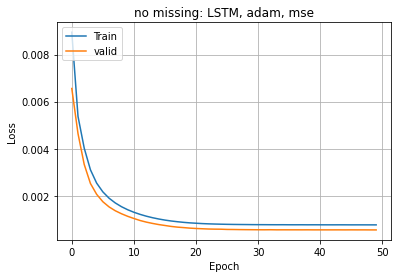

In [0]:
plot_loss('LSTM', 'adam', 'mse', model_history, 'no missing: ')

mse on train: 0.0007616502144614497
mse on test: 0.000549571778397355


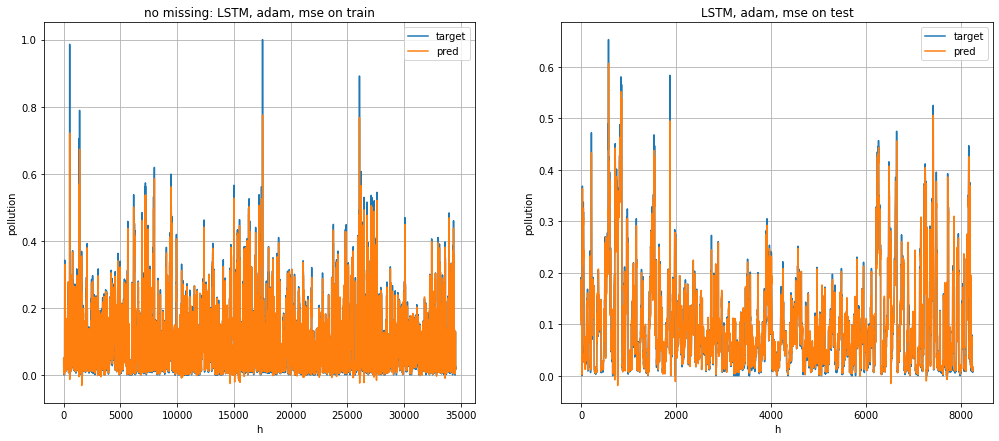

In [0]:
plot_performance('LSTM', 'adam', 'mse', model, hour_train_f, hour_train_t, hour_test_f, hour_test_t, desc='no missing: ')

In [0]:
imput_history = model_imput.fit(hour_train_imput_f, hour_train_imput_t, validation_data=(hour_test_f, hour_test_t), epochs=50, batch_size=256)

Train on 34536 samples, validate on 8255 samples
Epoch 1/50
34536/34536 [==============================] - 9s 253us/step - loss: 0.0212 - val_loss: 0.0120
Epoch 2/50
34536/34536 [==============================] - 8s 244us/step - loss: 0.0083 - val_loss: 0.0079
Epoch 3/50
34536/34536 [==============================] - 8s 242us/step - loss: 0.0061 - val_loss: 0.0062
Epoch 4/50
34536/34536 [==============================] - 9s 250us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 5/50
34536/34536 [==============================] - 8s 244us/step - loss: 0.0041 - val_loss: 0.0041
Epoch 6/50
34536/34536 [==============================] - 9s 247us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 7/50
34536/34536 [==============================] - 8s 243us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/50
34536/34536 [==============================] - 8s 244us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/50
34536/34536 [==============================] - 8s 241us/step - loss: 0.0024 - val_loss: 0.00

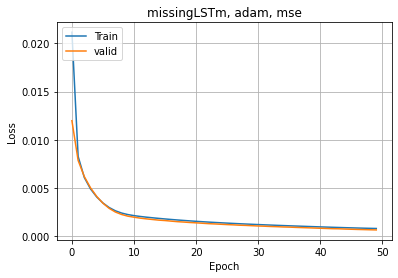

In [0]:
plot_loss('LSTm', 'adam', 'mse', imput_history, 'missing')

mse on train: 0.0007872557181684624
mse on test: 0.0006449183574378455


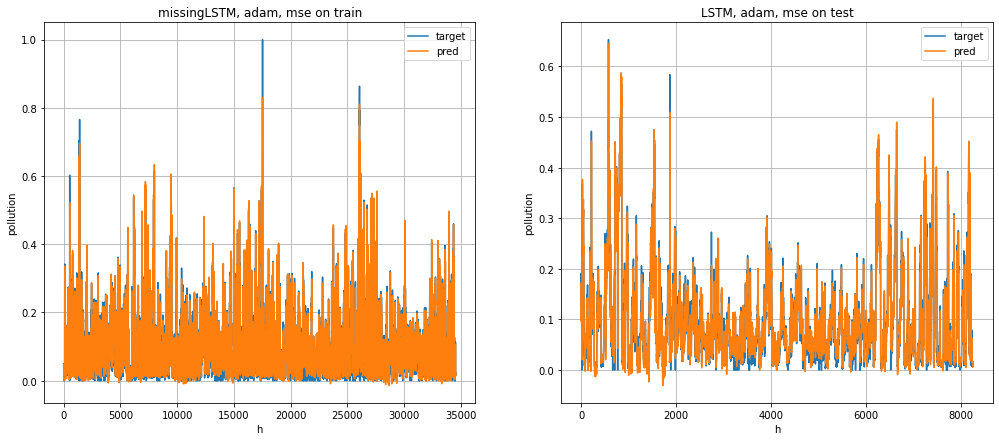

In [0]:
plot_performance('LSTM', 'adam', 'mse', model_imput, hour_train_imput_f.astype('float32'), hour_train_imput_t.astype('float32'), hour_test_f, hour_test_t, desc='missing')